In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import quad, cumtrapz, odeint
from tqdm import tqdm

import AMC

import matplotlib as mpl
mpl.rcParams['font.size'] = 18.0

1.164e+02, 1.778e+10
2.117e+05
1.5456911788188752


In [3]:
G_N = 4.302e-3

In [4]:
c = 100

def f_NFW(x):
    return np.log(1+x) - x/(1+x)

In [32]:
def calc_alphasq(c):
    return (3/c**2) + (1/(2*f_NFW(c)))*(c-3)/(c+1)

def calc_beta(c):
    return (c**3 - (2*c)*(1+c)*f_NFW(c))/((2*(1+c)**2*f_NFW(c)**2))

In [33]:
print(calc_alphasq(10000))
print(calc_beta(10000))

0.060873005257134925
74.0330860950654


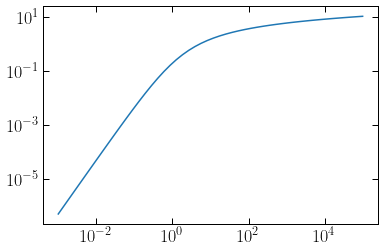

In [5]:
x_list = np.geomspace(1e-3, 1e5)

plt.figure()

plt.loglog(x_list, f_NFW(x_list))

plt.show()

In [6]:
print(f_NFW(100)/f_NFW(10000))

0.44150827464840825


In [7]:
A = 1.34
zeta = 0.07
t_dyn = 2.4e9
t_MW = 13.5e9
M_MW = 1e12

In [8]:
def dmdt(m, t):
    return -A*(m/t_dyn)*(m/M_MW)**zeta

In [9]:
def get_final_mass(m_i):
    t_list = np.linspace(0, t_MW, 1000)
    return odeint(dmdt, m_i, t_list).flatten()[-1]

In [10]:
rho_s = 0.014
R_s_NFW = 16.1e3
def Menc_MW(R):
    return 4*np.pi*rho_s*R_s_NFW**3*f_NFW(R/R_s_NFW)

In [11]:
res = get_final_mass(1e-5)

In [12]:
mi_list = np.geomspace(3.3e-19, 5.1e-5, 100)

In [13]:
mf_list = np.array([get_final_mass(mi) for mi in mi_list])

In [14]:
def final_anal(m_i):
    return m_i*(1 + zeta*(m_i/M_MW)**zeta*(A*t_MW/t_dyn))**(-1/zeta)

In [15]:
print(final_anal(-3.450139335880547e-22))

(-3.336699747275143e-22+2.488440902250543e-24j)


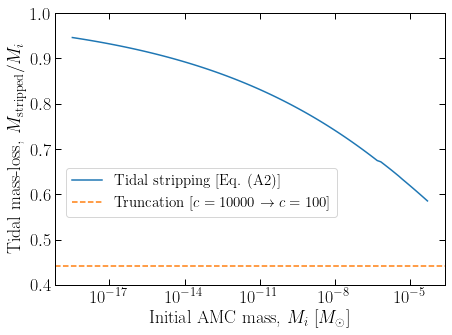

In [28]:
#print(mf_list)

plt.figure(figsize=(7,5))

plt.semilogx(mi_list, mf_list/mi_list, label='Tidal stripping [Eq. (A2)]')
#plt.semilogx(mi_list, final_anal(mi_list)/mi_list, linestyle=':')


plt.xlabel("Initial AMC mass, $M_i$ [$M_\odot$]")
plt.ylabel("Tidal mass-loss, $M_\mathrm{stripped}/M_i$")

plt.axhline(f_NFW(100)/f_NFW(10000), linestyle='--', color="C1", label=r"Truncation [$c = 10000 \rightarrow c = 100$]")

plt.legend(loc=(0.03, 0.25))

plt.ylim(0.4, 1)
mi
plt.savefig("../plots/TidalMassLoss.pdf", bbox_inches='tight')

plt.show()

#### Tidal Radius

Eq. (3) of https://arxiv.org/abs/1711.05276:

$$r_{\mathrm{t}}=R\left(\frac{m}{3 M}\right)^{1 / 3}$$

In [17]:

def r_tidal(m, R=8e3):
    x = R/R_s_NFW
    #print(x**2/(1+x)**2/f_NFW(x))
    kappa = 3 - x**2/(1+x)**2/f_NFW(x)
    #print(kappa)
    return R*(m/(kappa*Menc_MW(R)))**(1/3)

In [18]:
pc_per_m = 3.24078e-17
def R_AMC(m):
    return 1.4e11*pc_per_m*(m/1e-10)**(1/3)

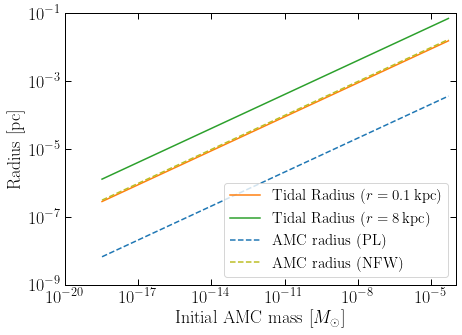

In [19]:
plt.figure(figsize=(7,5))

plt.loglog(mi_list, r_tidal(mi_list, R=0.1e3), label='Tidal Radius ($r = 0.1\,\mathrm{kpc}$)', color='C1')
plt.loglog(mi_list, r_tidal(mi_list, R=8e3), label='Tidal Radius ($r = 8\,\mathrm{kpc}$)', color='C2')

plt.loglog(mi_list, R_AMC(mi_list), label = "AMC radius (PL)", linestyle='--', color='C0')
plt.loglog(mi_list, (65/1.4)*R_AMC(mi_list), label = "AMC radius (NFW)", linestyle='--', color='C8')

plt.legend()

plt.xlim(1e-20, 1e-4)
plt.ylim(1e-9, 1e-1)

plt.xlabel("Initial AMC mass [$M_\odot$]")
plt.ylabel("Radius [pc]")

plt.savefig("../plots/TidalRadii_v1.pdf", bbox_inches='tight')
plt.show()

In [20]:
delta_list = np.linspace(0.1, 20, 100)

In [21]:
R_NFW_list = 0.0*delta_list
R_PL_list = 0.0*delta_list

In [22]:
for i, delta in enumerate(delta_list):
    AMC_NFW = AMC.AMC(1e-10, delta, profile="NFW")
    R_NFW_list[i] = AMC_NFW.R
    
    AMC_PL = AMC.AMC(1e-10, delta, profile="PL")
    R_PL_list[i] = AMC_PL.R

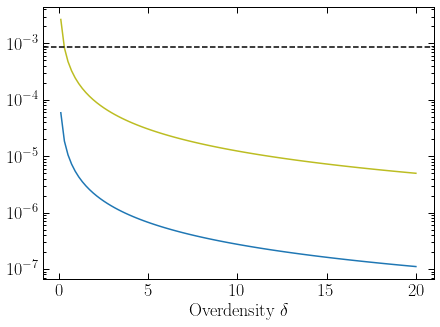

In [23]:
plt.figure(figsize=(7,5))

plt.semilogy(delta_list, R_PL_list, color="C0")
plt.semilogy(delta_list, R_NFW_list, color="C8")

#plt.axhline(r_tidal(1e-10, R=0.1e3), color='k', linestyle='--')
plt.axhline(r_tidal(1e-10, R=8e3), color='k', linestyle='--')


plt.xlabel("Overdensity $\delta$")

plt.show()

# NEED TO ADJUST FOR THE ENCLOSED MASS IN THE MW (NOT THE TOTAL MASS!)

In [24]:
print(Menc_MW(200e3)/1e12)

1.2271631375891185


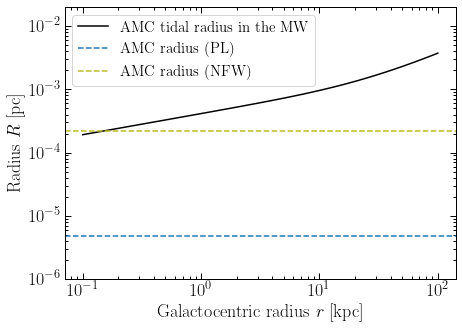

In [25]:
r_GC_list = np.geomspace(0.1e3, 100e3)

M0 = 1e-10

plt.figure(figsize=(7,5))

plt.loglog(r_GC_list/1e3, r_tidal(M0, R=r_GC_list), color='k', label='AMC tidal radius in the MW')

AMC_PL = AMC.AMC(1e-10, 1.0, profile="PL")
plt.axhline(AMC_PL.R, linestyle='--', color='C0', label='AMC radius (PL)')

AMC_NFW = AMC.AMC(1e-10, 1.0, profile="NFW")
plt.axhline(AMC_NFW.R, linestyle='--', color='C8', label='AMC radius (NFW)')

plt.xlabel("Galactocentric radius $r$ [kpc]")

plt.ylabel("Radius $R$ [pc]")

plt.ylim(1e-6, 2e-2)

plt.legend(loc='upper left')

plt.savefig("../plots/TidalRadii_v2.pdf", bbox_inches='tight')
plt.show()